In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [2]:
def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u[..., :-1, :], v[..., :-1]

def unstagger_w(wgrid):
    """ Interpolate w to values at vetical grid cell centres.
    The shape of the returned array is 1 less than that of
    the input array yin the z dimension
    :arg wgrid: w velocity component values with axes (z,...)
    :type wgrid: :py:class:`numpy.ndarray`
    :returns w: w component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    w = np.add(wgrid[:-1, ...], wgrid[1:, ...]) / 2
    return w

In [3]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/02_SVB_barotropic_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/02_noSVB_barotropic/'
levels = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 
          73, 78, 83, 88, 93, 98,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels,  chunks=None)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels, chunks=None)

In [4]:
nx = 512
ny = 612
nz = 76
nt = 720
dt = 600 # sec
z1 = 26 # Zl[26] = -101.750 m
z2 = 38 # Zl[38] = -202.200 m
z3 = 46 # Zl[46] = -300.2 m
z4 = 55 # Zl[55] = -495.700 m

depth_nob = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# centers mask
hFacC = ds2['hFacC'][:].data
hfac = np.ma.masked_values(hFacC, 0)
masknoSVB = np.ma.getmask(hfac)
time = np.arange(0,720)*600

# centers mask bathy with bay
depth_bay = ds.Depth[:].data
hFacCSVB = ds['hFacC'][:].data
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)

## Barotropic APE

Consider only barotropic contribution from SSH. 
$$APE_{BT}= \frac{1}{2}\int\int \rho_0 g [H-H_0]^2~dx~dy= \frac{1}{2}\int\int \rho_0 g \eta^2~ dx~dy $$

where $H_0$ is the reference depth, $H$ is the depth of the water column, $\eta=H-H_0$ is the free surface, $\rho_0$ is a constant referecne density which I chose to be the average of the initial desnity profile (maybe I should do a weighted avg or something like that). I got this from Dolzhanky book but also on Vallis.

In [53]:
# ### Barotropic APE
end = 144

# Reference rho0 = mean(rho_ref)
rho0 = np.nanmean(ds.rhoRef.data)
g = 9.81

# Initialize arrays to save EP time series
Ep = np.zeros_like(time[:end])
Epsvbmask = np.zeros_like(time[:end])
EpSVB = np.zeros_like(time[:end])
EpnoSVB = np.zeros_like(time[:end])

# grid variables
dA = ds.rA.data
dAnS = ds2.rA.data
vol_chafa = np.nansum(depth_bay * dA)

for tt in range(len(time[:end])):
    ETASVB = np.ma.masked_array(ds.ETAN.data[tt,...], mask=maskSVB[0,...])
    ETAnoSVB = np.ma.masked_array(ds2.ETAN.data[tt,...], mask=masknoSVB[0,...])
    ETAanom = np.ma.masked_array(ds.ETAN.data[tt,...]-ds2.ETAN.data[tt,...], mask=masknoSVB[0,...])
    ETAanom_svb = np.ma.masked_array(ds.ETAN.data[tt,...]-ds2.ETAN.data[tt,...], mask=maskSVB[0,...])
   
    #EpSVB[tt]     = 0.5 * rho0 * g * np.nansum((ETASVB)**2 * dA)
    #EpnoSVB[tt]   = 0.5 * rho0 * g * np.nansum((ETAnoSVB)**2 * dAnS)
    #Ep[tt]        = 0.5 * rho0 * g * np.nansum((ETAanom)**2 * dAnS)
    #Epsvbmask[tt] = 0.5 * rho0 * g * np.nansum((ETAanom_svb)**2 * dA)
    EpSVB[tt]     = rho0 * g * ETASVB+depth_bay * vol_chafa
    EpnoSVB[tt]   = rho0 * g * ETAnoSVB+depth_bay * vol_chafa
    Ep[tt]        = rho0 * g * ETAanom+depth_bay * vol_chafa
    Epsvbmask[tt] = rho0 * g * ETAanom_svb+depth_bay * vol_chafa


np.savez('PE_barotropic_test', EpSVB=EpSVB, EpnoSVB=EpnoSVB, Ep=Ep, Epsvbmask=Epsvbmask ) 

ValueError: setting an array element with a sequence.

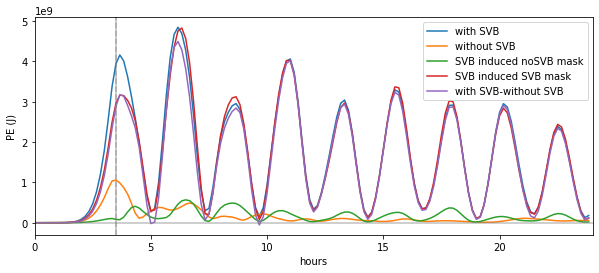

In [6]:
Ep_baro = np.load('PE_barotropic_test.npz')
EpSVB = Ep_baro['EpSVB'][:]
EpnoSVB = Ep_baro['EpnoSVB'][:]
Ep = Ep_baro['Ep'][:]
Epsvbmask = Ep_baro['Epsvbmask'][:]

fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.axvline(3.5, color='0.5', alpha=0.5)
ax.plot(time[:end]/3600, EpSVB, '-', label='with SVB')
ax.plot(time[:end]/3600, EpnoSVB, '-', label='without SVB')
ax.plot(time[:end]/3600, Ep, '-', label='SVB induced noSVB mask')
ax.plot(time[:end]/3600, Epsvbmask, '-', label='SVB induced SVB mask')
ax.plot(time[:end]/3600, (EpSVB-EpnoSVB), '-', label='with SVB-without SVB')
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('hours')
ax.set_ylabel('PE (J)')
ax.set_xlim(0,time[end]/3600)
ax.axvline(3.5, color='0.5', alpha=0.5, linestyle='--')
ax.axhline(0, color='0.5', alpha=0.5)

### Kinetic energy

$$KE(t)=\frac{1}{2}\int\int\int \rho (u^2+v^2+w^2)~dx~dy~dz,$$

where $\rho=\rho(x,y,z,t)=\rho_{anoma}(x,y,z,t)+\rho_{ref}(z)$ from model output, but for this barotropic run $\rho=\rho_0$


In [7]:
# # time index up to which we calculate KE
# end = 144

# # intialize arrays to save KE time series
# K = np.zeros_like(time[:end])
# K_svbmask = np.zeros_like(time[:end])
# KSVB = np.zeros_like(time[:end])
# KnoSVB = np.zeros_like(time[:end])

# # Expand grid variables with and without (nS) the bay to be 3D
# dA  = np.expand_dims(ds.rA.data,0) + np.zeros((nz,ny,nx))
# drF = np.expand_dims(np.expand_dims(ds.drF.data,1),1) + np.zeros((nz,ny,nx))
# vol = dA * drF * hFacCSVB

# dAnS  = np.expand_dims(ds2.rA.data,0) + np.zeros((nz,ny,nx))
# drFnS = np.expand_dims(np.expand_dims(ds2.drF.data,1),1) + np.zeros((nz,ny,nx))
# volnS = dAnS * drFnS * hFacC

# # Calculate KE at every time output (this is super slow but xarray is a pain along the time axis)
# for tt in range(len(time[:end])):

#     # Unstagger velocities into cell centers [everythng becomes size (nz-1,ny-1,nx-1)]
#     U,V = unstagger(ds.UVEL.data[tt,...],ds.VVEL.data[tt,...])
#     W   = unstagger_w(ds.WVEL.data[tt,...])

#     UnS,VnS = unstagger(ds2.UVEL.data[tt,...],ds2.VVEL.data[tt,...])
#     WnS     = unstagger_w(ds2.WVEL.data[tt,...])

#     # Apply land mask to velocities
#     UU = np.ma.masked_array(U[:-1,...], mask=maskSVB[:-1,:-1,:-1])
#     VV = np.ma.masked_array(V[:-1,...], mask=maskSVB[:-1,:-1,:-1])
#     WW = np.ma.masked_array(W[:,:-1,:-1], mask=maskSVB[:-1,:-1,:-1])

#     UUnS = np.ma.masked_array(UnS[:-1,...], mask=masknoSVB[:-1,:-1,:-1])
#     VVnS = np.ma.masked_array(VnS[:-1,...], mask=masknoSVB[:-1,:-1,:-1])
#     WWnS = np.ma.masked_array(WnS[:,:-1,:-1], mask=masknoSVB[:-1,:-1,:-1])

#     UUanom_SVBmask = np.ma.masked_array(U[:-1,...] - UnS[:-1,...], mask=maskSVB[:-1,:-1,:-1])
#     VVanom_SVBmask = np.ma.masked_array(V[:-1,...] - VnS[:-1,...], mask=maskSVB[:-1,:-1,:-1])
#     WWanom_SVBmask = np.ma.masked_array(W[:,:-1,:-1] - WnS[:,:-1,:-1], mask=maskSVB[:-1,:-1,:-1])

#     UUanom = np.ma.masked_array(U[:-1,...] - UnS[:-1,...], mask=masknoSVB[:-1,:-1,:-1])
#     VVanom = np.ma.masked_array(V[:-1,...] - VnS[:-1,...], mask=masknoSVB[:-1,:-1,:-1])
#     WWanom = np.ma.masked_array(W[:,:-1,:-1] - WnS[:,:-1,:-1], mask=masknoSVB[:-1,:-1,:-1])

#     ## Calculate KE
#     # with SVB and anomaly SVB-noSVB (should I use anomaly of density as well?)
#     KSVB[tt] = 0.5 * np.nansum(rho0 * (UU**2 + VV**2 + WW**2) * vol[:-1,:-1,:-1])

#     K[tt] = 0.5 * np.nansum(rho0 * (UUanom**2 + VVanom**2 + WWanom**2) * volnS[:-1,:-1,:-1])

#     K_svbmask[tt] = 0.5 * np.nansum(rho0 * 
#                                     (UUanom_SVBmask**2 + VVanom_SVBmask**2 + WWanom_SVBmask**2) *
#                                     vol[:-1,:-1,:-1])

#     # without SVB
#     KnoSVB[tt] = 0.5 * np.nansum(rho0 * (UUnS**2 + VVnS**2 + WWnS**2) * volnS[:-1,:-1,:-1])


# np.savez('KE_barotropic', KSVB=KSVB, KnoSVB=KnoSVB, K=K, K_svbmask=K_svbmask) 

Text(0, 0.5, 'KE (J)')

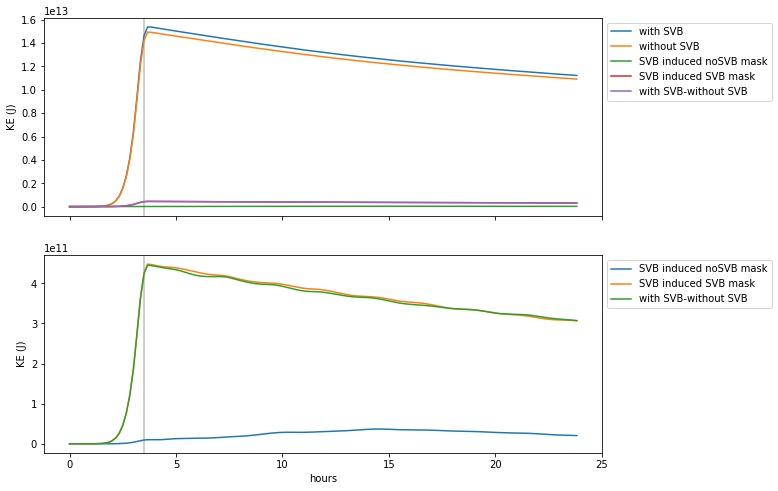

In [8]:
KE_baro = np.load('KE_barotropic.npz')
KSVB = KE_baro['KSVB'][:144]
KnoSVB = KE_baro['KnoSVB'][:144]
K = KE_baro['K'][:144]
K_svbmask = KE_baro['K_svbmask'][:144]

fig,(ax,ax2) = plt.subplots(2,1,figsize=(10,8), sharex=True)

ax.axvline(3.5, color='0.5', alpha=0.5)
ax.plot(time[:end]/3600, KSVB-KSVB[0], '-', label='with SVB')
ax.plot(time[:end]/3600, KnoSVB-KnoSVB[0], '-', label='without SVB')
ax.plot(time[:end]/3600, K-K[0], '-', label='SVB induced noSVB mask')
ax.plot(time[:end]/3600, K_svbmask-K_svbmask[0], '-', label='SVB induced SVB mask')
ax.plot(time[:end]/3600, (KSVB-KnoSVB)-(KSVB-KnoSVB)[0], '-', label='with SVB-without SVB')
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('KE (J)')

ax2.axvline(3.5, color='0.5', alpha=0.5)
ax2.plot(time[:end]/3600, K-K[0], '-', label='SVB induced noSVB mask')
ax2.plot(time[:end]/3600, K_svbmask-K_svbmask[0], '-', label='SVB induced SVB mask')
ax2.plot(time[:end]/3600, (KSVB-KnoSVB)-(KSVB-KnoSVB)[0], '-', label='with SVB-without SVB')
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_xlabel('hours')
ax2.set_ylabel('KE (J)')

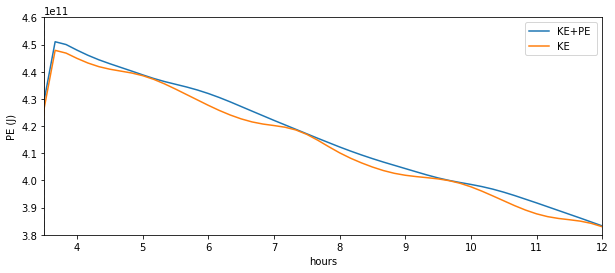

In [38]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.axvline(3.5, color='0.5', alpha=0.5)
ax.plot(time[:end]/3600, K_svbmask[:]+Epsvbmask[:], '-', label='KE+PE ')
ax.plot(time[:end]/3600, K_svbmask, '-', label='KE ')

ax.set_ylim(3.8E11,4.6E11)
ax.set_xlim(3.5,12)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('hours')
ax.set_ylabel('PE (J)')
ax.axvline(3.5, color='0.5', alpha=0.5, linestyle='--')
ax.axhline(0, color='0.5', alpha=0.5)

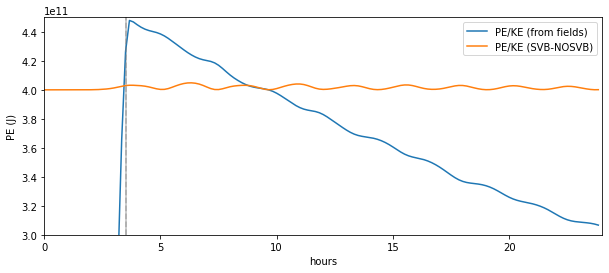

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.axvline(3.5, color='0.5', alpha=0.5)
ax.plot(time[:end]/3600, K_svbmask, '-', label='PE/KE (from fields)')
ax.plot(time[:end]/3600, Epsvbmask+4E11, '-', label='PE/KE (SVB-NOSVB)')


ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('hours')
ax.set_ylabel('PE (J)')
ax.set_xlim(0,time[end]/3600)
ax.set_ylim(3E11,4.5E11)
ax.axvline(3.5, color='0.5', alpha=0.5, linestyle='--')
ax.axhline(0, color='0.5', alpha=0.5)

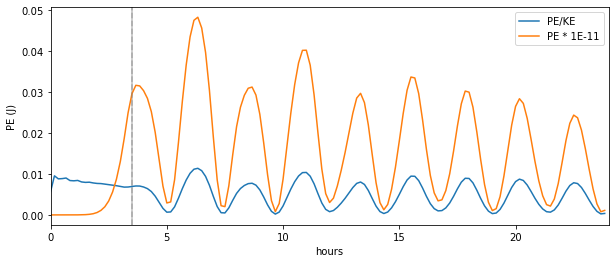

In [52]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.axvline(3.5, color='0.5', alpha=0.5)
ax.plot(time[:end]/3600, (Epsvbmask)/K_svbmask, '-', label='PE/KE')
ax.plot(time[:end]/3600, 1E-11*(Epsvbmask), '-', label='PE * 1E-11')


ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('hours')
ax.set_ylabel('PE (J)')
ax.set_xlim(0,time[end]/3600)
ax.axvline(3.5, color='0.5', alpha=0.5, linestyle='--')


In [50]:
np.corrcoef(Epsvbmask+K_svbmask,K_svbmask)

array([[1.        , 0.99996218],
       [0.99996218, 1.        ]])